---
title: Finite Volume
subject: Jax Approximate Ocean Models
subtitle: How can I use the Grid Operations to deal with staggered grids?
short_title: Finite Volume
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CNRS
      - MEOM
    orcid: 0000-0002-6739-0053
    email: jemanjohnson34@gmail.com
  - name: Takaya Uchida
    affiliations:
      - FSU
    orcid: https://orcid.org/0000-0002-8654-6009
    email: tuchida@fsu.edu
license: CC-BY-4.0
keywords: jax, shallow water model, differentiable
abbreviations:
    SW: Shallow Water
    QG: Quasi-Geostrophic
    PDE: Partial Differential Equation
    RHS: Right Hand Side
---

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import numpy as np
import kernex as kex
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from jaxtyping import Array
import einops
import finitediffx as fdx
import jaxsw._src.operators.functional as F
import jaxsw._src.operators.functional.interp as F_interp

# import jaxsw._src.operators.functional.finitevol as fv
from jaxsw._src.operators.functional import grid as F_grid
from jaxsw._src.operators.functional import cgrid as C_grid
from jaxsw._src.boundaries import functional as F_bc
from jaxsw._src.domain.base import Domain
from jaxsw._src.fields.base import Field
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Core Operations

* Interpolation
* Difference
* Pad

**Difference**.
These operations allow us to deal with the difference scheme for finite volumes.


**Padding**. 
We can also deal with boundary conditions via the padding.


**Pseudo-Code**


```python
u: Array = ...

# interpolation
u_on_h = F_grid.interp(u, axis=0, method="linear")

# difference
du_dx = F_grid.difference(u, step_size=dx, axis=0, method="right")
du_dy = F_grid.difference(u, step_size=dy, axis=1, method="right")

# padding ("edge", "constant", "wrap")
u_pad = F_grid.pad(u, axis=0, pad_width=(1,1), method="edge")

# padding (boundaries)
u_pad = F_grid.pad_bc(u, axis=0, pad_width=(1,1), method="dirichlet")
```

## 1D Arakawa C-Grid

```python
+ -- ⋅ -- +
u -- u̅ -- u
+ -- ⋅ -- +
```


```python
# QOI
q: Array["Nx"] = ...
# U-Velocity
u: Array["Nx"] = ...
```

In [2]:
import typing as tp

In [3]:
from jaxsw._src.fields.continuous import ContinuousField

In [4]:
# initialize domain
num_points = 15
u_domain = Domain.from_numpoints(
    xmin=(-2.0 * jnp.pi,), xmax=(2.0 * jnp.pi,), N=(num_points,)
)
# q_domain = Domain.from_numpoints(xmin=(-2*jnp.pi,), xmax=(2*jnp.pi,), N=(num_points,), stagger=("right",))
q_domain = Domain.from_numpoints(
    xmin=(-2.0 * jnp.pi,), xmax=(2.0 * jnp.pi,), N=(num_points,), stagger=("right",)
)

# initialize functions
fn = lambda x: jnp.sin(x).squeeze()

u_true = ContinuousField(u_domain, fn=fn)
q_true = ContinuousField(domain=q_domain, fn=fn)
u_true, q_true

(ContinuousField(
   values=f64[16],
   domain=Domain(
     xmin=(-6.283185307179586,),
     xmax=(7.180783208205241,),
     dx=(0.8975979010256552,)
   ),
   fn=<function <lambda>>
 ),
 ContinuousField(
   values=f64[16],
   domain=Domain(
     xmin=(-5.834386356666759,),
     xmax=(7.629582158718069,),
     dx=(0.8975979010256552,)
   ),
   fn=<function <lambda>>
 ))

In [5]:
# # initialize functions
# fn = lambda x: jnp.sin(x).squeeze()
# dfn = lambda x: jax.grad(fn)(x).squeeze()
# d2fn = lambda x: jax.grad(dfn)(x).squeeze()

# # create fields
# u_true = Field.init_from_fn(domain=u_domain, fn=fn)
# q_true = Field.init_from_fn(domain=q_domain, fn=fn)
# u_true, q_true

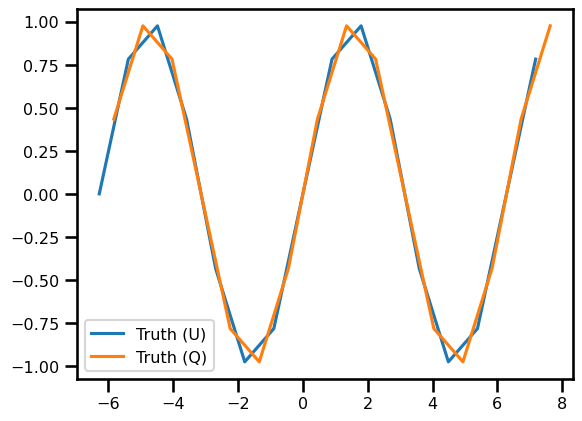

In [6]:
fig, ax = plt.subplots()

ax.plot(u_true.domain.coords, u_true[:], label="Truth (U)")
ax.plot(q_true.domain.coords, q_true[:], label="Truth (Q)")

plt.legend()
plt.show()

## Interpolation

This demonstrates how we can move between domains.


* q ---> u
* u ---> q

### Example Functionality

* Field Domain Transformation
* Field Stagger
* Field Differences
* Field Padding
* Arakawa C-Grid Goodies

---

### Domain Stagger

> This will allow users to stagger their grids once they are initialized.
> It basically limits users to move their grid around along with their limits.
> 1) User chooses how to choose their domain
> 2) Transform to that domain



```python
direction: tp.Tuple(str) = ("right", "right") # right, left, inner, outer, None
stagger: tp.Tuple(bool) = (False, False) # True | False

# create domain:
# [Nx,Ny] --> [Nx,Ny] | [xmin,xmax] --> [xmin + dx, xmax + dx]
new_domain: Domain = F_grid.stagger_domain(domain, direction=("right", "right"), stagger=(False, False))
u_stagger: Field = F_grid.field_transform(u, domain=new_domain, *args, **kwargs)

# EXAMPLE DOMAINS
# [Nx,Ny] --> [Nx,Ny] | [xmin,xmax] --> [xmin + dx, xmax - dx]
new_domain: Domain = F_grid.stagger_domain(domain, direction=("inner", "inner"), stagger=(False, False))

# [Nx,Ny] --> [Nx,Ny] | [xmin,xmax] --> [xmin + 1/2 dx, xmax - 1/2 dx]
new_domain: Domain = F_grid.stagger_domain(domain, direction=("inner", "inner"), stagger=(True, True))

# [Nx,Ny] --> [Nx,Ny] | [xmin,xmax] --> [xmin - 1/2 dx, xmax + 1/2 dx]
new_domain: Domain = F_grid.stagger_domain(domain, direction=("outer", "outer"), stagger=(True, True))

```

In [7]:
# initialize psi domain
num_points = 10  # the more points, the better linear interpolation
psi_domain = Domain.from_numpoints(
    xmin=(-2.0 * jnp.pi,), xmax=(2.0 * jnp.pi,), N=(num_points,)
)

# create continuous field
psi = Field.init_from_fn(domain=psi_domain, fn=lambda x: jnp.sin(x).squeeze())

# stagger grid for u points
u_domain = C_grid.stagger_domain(psi.domain, direction=("right",), stagger=(True,))
assert psi.domain.Nx == u_domain.Nx

# stagger grid for u points
u_domain = C_grid.stagger_domain(psi.domain, direction=("right",), stagger=(False,))
assert psi.domain.Nx == u_domain.Nx

### Field-2-Field Transformation

> This will allow users to transform their field from one domain to another.
> This boils down to an interpolation problem whereby we


$$
\begin{aligned}
\text{Domain A}: && && \vec{\mathbf{x}} &\in \boldsymbol{\Omega}_A \in \mathbb{R}^{Ds} \\
\text{Domain B}: && && \vec{\mathbf{x}} &\in \boldsymbol{\Omega}_B \in \mathbb{R}^{Ds} \\
\text{Transform}: && && \boldsymbol{\Omega}_Z &= \boldsymbol{T}(\boldsymbol{\Omega}_A)
\end{aligned}
$$

Now, we need to find a transformation 

Notice we are restricting ourselves to the same coordinate space, $\mathbb{R}^{D_s}$. 
This package only currently implements the Euclidean space with Cartesian coordinates. 
Later, we can think a bit more about we can extend this to spherical coordinates.

```python
u: Field = ...
new_domain: Domain = ...

u_on_v: Field = F_grid.field_transform(u, domain=new_domain, *args, **kwargs)

```

In [8]:
# initialize psi domain
num_points = 10  # the more points, the better linear interpolation
psi_domain = Domain.from_numpoints(
    xmin=(-2.0 * jnp.pi,), xmax=(2.0 * jnp.pi,), N=(num_points,)
)

# create continuous field
psi = Field.init_from_fn(domain=psi_domain, fn=lambda x: jnp.sin(x).squeeze())

# stagger grid for u points
u_domain = C_grid.stagger_domain(psi.domain, direction=("right",), stagger=(True,))

# convert to grid!
psi_on_u: Field = F_interp.field_domain_transform(psi, u_domain)

We also may already have a grid that we want to interpolate to. 
This is very common when we are dealing with arakawa C-Grids whereby we need to do constant transformations between the `u`, `v`, `h`, and `tracers`.

In [9]:
# initialize psi domain
num_points = 10  # the more points, the better linear interpolation
psi_domain = Domain.from_numpoints(
    xmin=(-2.0 * jnp.pi,), xmax=(2.0 * jnp.pi,), N=(num_points,)
)
u_domain = Domain.from_numpoints(
    xmin=(-2.0 * jnp.pi,), xmax=(2.0 * jnp.pi,), N=(num_points,), stagger=("right",)
)

# create continuous field
psi = Field.init_from_fn(domain=psi_domain, fn=lambda x: jnp.sin(x).squeeze())
u = Field.init_from_fn(domain=u_domain, fn=lambda x: jnp.sin(x).squeeze())

# convert
psi_on_u: Field = F_interp.field_domain_transform(psi, u_domain)

# check that this runs
_ = psi_on_u * u

**Example**: We have the psi

In [37]:
def make_fv_1D(num_points: int = 20):
    """The more points, the better the interpolation!"""
    # initialize domain
    psi_domain = Domain.from_numpoints(
        xmin=(-2.0 * jnp.pi,), xmax=(2.0 * jnp.pi,), N=(num_points,)
    )
    u_domain = Domain.from_numpoints(
        xmin=(-2.0 * jnp.pi,), xmax=(2.0 * jnp.pi,), N=(num_points,), stagger=("right",)
    )

    # create continuous field
    u = ContinuousField(domain=u_domain, fn=lambda x: jnp.sin(x).squeeze())
    psi = ContinuousField(domain=psi_domain, fn=lambda x: jnp.sin(x).squeeze())

    return psi, u


psi, u = make_fv_1D(20)

# create new domain
new_domain = C_grid.stagger_domain(psi.domain, direction=("right",), stagger=(True,))

# stagger it
psi_on_new = F_interp.field_domain_transform(psi, new_domain)

# do it automatically
psi_on_u = F_interp.field_domain_transform(psi, u.domain)

In [41]:
from jaxsw._src.operators.constant import Constant

Constant(2.0)(psi_on_u)

Field(
  values=f64[21],
  domain=Domain(
    xmin=(-5.9524913436438185,),
    xmax=(7.2752671977868895,),
    dx=(0.6613879270715354,)
  )
)

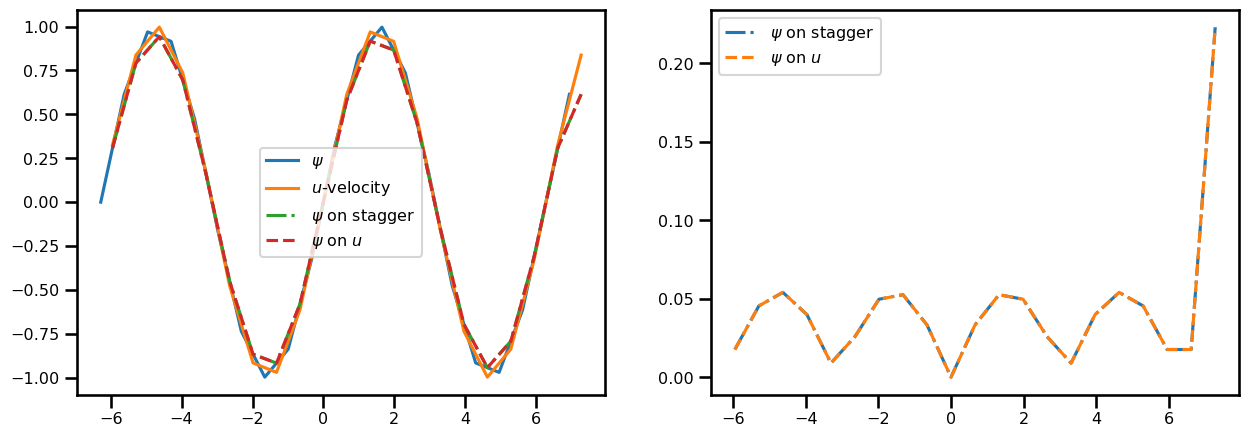

In [38]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
ax[0].plot(psi.domain.coords, psi[:], label="$\psi$")
ax[0].plot(u.domain.coords, u[:], label="$u$-velocity")
ax[0].plot(
    psi_on_new.domain.coords, psi_on_new[:], label="$\psi$ on stagger", linestyle="-."
)
ax[0].plot(psi_on_u.domain.coords, psi_on_u[:], label="$\psi$ on $u$", linestyle="--")
ax[0].legend(loc="best")

err_fn = lambda x, y: jnp.abs(x - y)

ax[1].plot(
    psi_on_new.domain.coords,
    err_fn(u[:], psi_on_u[:]),
    label="$\psi$ on stagger",
    linestyle="-.",
)
ax[1].plot(
    psi_on_u.domain.coords,
    err_fn(u[:], psi_on_u[:]),
    label="$\psi$ on $u$",
    linestyle="--",
)
ax[1].legend(loc="best")


plt.show()

### Field Selection

Many cases, we need to select the interior points of our grid.
This happens a lot when we are dealing with ghost points and we only want to work with the interior points for interpolation and derivatives.

**Padding**:

* Along Axis
* All Axis
* Custom BCs

**Interior**:
* Along Axis
* All Axis

```python
u: Field ...

# slice interior points
u: Field = C_grid.slice_interior_axis(u, axis=0)

# add along axis
u: Field = C_grid.pad_axis(u, axis=0)

# slice all interior axis
u: Field = C_grid.slice_interior_all(u)
```

In [12]:
sum((0, 1))

1

In [ ]:
C_grid.slice_interior_all

In [13]:
# initialize domain
num_points = 20  # the more points, the better linear interpolation
psi_domain = Domain.from_numpoints(
    xmin=(-2.0 * jnp.pi,), xmax=(2.0 * jnp.pi,), N=(num_points,)
)

# create continuous field
psi = ContinuousField(domain=psi_domain, fn=lambda x: jnp.sin(x).squeeze())

In [15]:
pad_width = ("both",)  # other options - ("both",) | ("right",) | ("left",) | (None,)

# do it along axis
psi_ghost_along = C_grid.pad_along_axis(psi, pad_width=pad_width, mode="reflect")

# do it on axis
psi_ghost_all = C_grid.pad_all_axis(psi, mode="reflect")

# check theyre the same
np.testing.assert_array_almost_equal(psi_ghost_along[:], psi_ghost_all[:])

# check sizes
assert (
    psi.domain.Nx[0]
    == psi_ghost_along.domain.Nx[0] - 2
    == psi_ghost_all.domain.Nx[0] - 2
)

```python

Domain.from_length(Lx, dx)

apply_function(u: Field, fn: tp.Callable)
```

### Field Differences

> This will allow users to take finite differences that are equivalent to finite volumes.


```python
direction: str = "right" # "right", "left", "up" "down"
difference: int = 1 # 1st or 2nd derivative

# finite difference methods

# 1st derivative: 
du_dx: Field = arakawac.difference(u, axis=0, derivative=1) # [Nx,Ny] --> [Nx-1,Ny]
du_dy: Field = arakawac.difference(u, axis=1, derivative=1) # [Nx,Ny] --> [Nx,Ny-1]

# 2nd derivative: 
d2u_dx2: Field = arakawac.difference(u, axis=0, derivative=2) # [Nx,Ny] --> [Nx-2,Ny]
d2u_dy2: Field = arakawac.difference(u, axis=1, derivative=2) # [Nx,Ny] --> [Nx,Ny-2]

# laplacian: 
u_lap: Field = arakawac.laplacian(u) # [Nx,Ny] --> [Nx-2,Ny-2]

# velocity
u_vel: Field = arakawac.velocity(psi) # [Nx,Ny] --> [Nx, Ny-1]
v_vel: Field = arakawac.velocity(psi) # [Nx,Ny] --> [Nx-1, Ny]

# divergence
div: Field = arakawac.divergence(u, v) # 

# vorticity
vort: Field = arakawac.vorticity(u, v) #

# kinetic energy

# advection
adv: Field = araka

```

**Arakawa Specifics**

```python
u_on_v = arakawac.u_on_v(u) 
v_on_u = arakawac.v_on_u(v)

h_on_u = arakawac.h_on_u(h)
h_on_v = arakawac.h_on_v(v)

h_on_q = arakawac.h_on_tracer(h)

```


::::{tab-set}
:::{tab-item} JSOM API
:sync: tab1
```python
# High-Level API (automatic)
u_on_q_hi = F_interp.field_interp(u_true, q_true)
```

**Pros**: Easy, Readable

**Cons**: Field API

:::

:::{tab-item} JSOM API (Under-the-hood)
:sync: tab1
```python
# interpolate
new_values = F_interp.domain_interp_1D(u_true.values, u_true.domain, q_true.domain)
# create new field
u_on_q_hi = Field(values=new_values, domain=q_true.domain)
```

**Pros**: Easy, Readable

**Cons**: Field API

:::

:::{tab-item} Functional API
:sync: tab1
```python
# Mid-Level API (no padding)
# extract values
u_values = u_true[:] # u.values

# interp params
method = "linear"
axis = 0

# apply interpolation
u_values = F_interp.interp(u_values, axis=axis, method=method)

# CODE TO CHANGE DOMAIN
u_domain = ...

# redo field
u: Field = Field(values=u_values, domain=u_domain)
```

:::


:::{tab-item} From Scratch
:sync: tab1
```python
# extract values
u_values = u_true[:] # u.values

# apply linear interpolation
u_values = 0.5 * (u_values[1:] + u_values[:-1])

# CODE TO CHANGE DOMAIN
u_domain = ...

# redo field
u: Field = Field(values=u_values, domain=u_domain)
```

:::




::::

In [12]:
q_true.domain.coords_axis.shape, q_true.domain.grid_axis.shape

((1, 111), (1, 111))

In [26]:
# High-Level API (automatic)
u_on_q_hi = F_interp.field_domain_transform(u_true, q_true, order=1, mode="wrap")
q_on_u_hi = F_interp.field_domain_transform(q_true, u_true, order=1, mode="wrap")
u_true, u_on_q_hi, q_true

(ContinuousField(
   values=f64[100],
   domain=Domain(
     xmin=(-6.283185307179586,),
     xmax=(6.283185307179586,),
     dx=(0.12693303650867852,)
   ),
   fn=<function <lambda>>
 ),
 Field(
   values=f64[111],
   domain=Domain(
     xmin=(-6.283185307179586,),
     xmax=(6.283185307179586,),
     dx=(0.1152878038014603,)
   )
 ),
 ContinuousField(
   values=f64[111],
   domain=Domain(
     xmin=(-6.283185307179586,),
     xmax=(6.283185307179586,),
     dx=(0.1152878038014603,)
   ),
   fn=<function <lambda>>
 ))

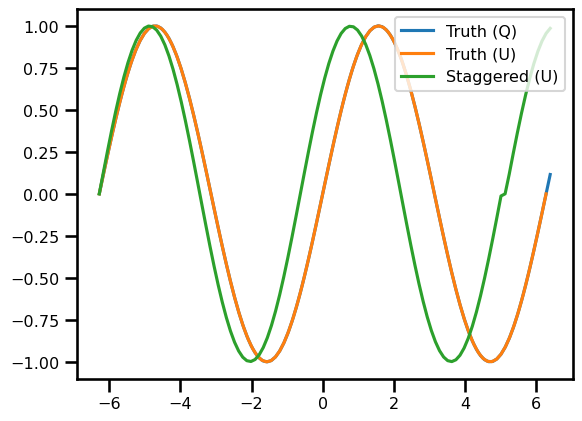

In [27]:
fig, ax = plt.subplots()

ax.plot(q_true.domain.coords, q_true[:], label="Truth (Q)")
ax.plot(u_true.domain.coords, u_true[:], label="Truth (U)")
ax.plot(u_on_q_hi.domain.coords, u_on_q_hi[:], label="Staggered (U)")

plt.legend()
plt.show()

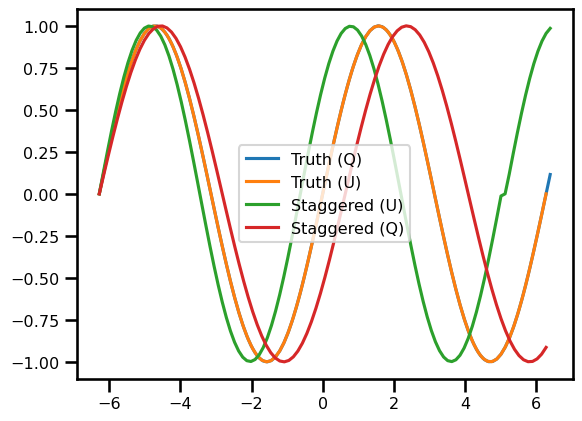

In [28]:
fig, ax = plt.subplots()

ax.plot(q_true.domain.coords, q_true[:], label="Truth (Q)")
ax.plot(u_true.domain.coords, u_true[:], label="Truth (U)")
ax.plot(u_on_q_hi.domain.coords, u_on_q_hi[:], label="Staggered (U)")
ax.plot(q_on_u_hi.domain.coords, q_on_u_hi[:], label="Staggered (Q)")

plt.legend()
plt.show()

## Difference


**APIs**:

* High-Level API - everything is automatic
* Mid-Level API - you use an external library that does everything for you
* Low-Level API - you implement your own custom difference operator (scratch, kernex)

In [29]:
# initialize functions
dfn = lambda x: jax.grad(fn)(x).squeeze()
d2fn = lambda x: jax.grad(dfn)(x).squeeze()

# create fields
du_dx_true = ContinuousField(u_domain, fn=dfn)
d2u_dx2_true = ContinuousField(u_domain, fn=d2fn)
u_true, du_dx_true, d2u_dx2_true

(ContinuousField(
   values=f64[100],
   domain=Domain(
     xmin=(-6.283185307179586,),
     xmax=(6.283185307179586,),
     dx=(0.12693303650867852,)
   ),
   fn=<function <lambda>>
 ),
 ContinuousField(
   values=f64[100],
   domain=Domain(
     xmin=(-6.283185307179586,),
     xmax=(6.283185307179586,),
     dx=(0.12693303650867852,)
   ),
   fn=<function <lambda>>
 ),
 ContinuousField(
   values=f64[100],
   domain=Domain(
     xmin=(-6.283185307179586,),
     xmax=(6.283185307179586,),
     dx=(0.12693303650867852,)
   ),
   fn=<function <lambda>>
 ))

In [30]:
from jaxsw._src.operators.functional import difference as F_diff

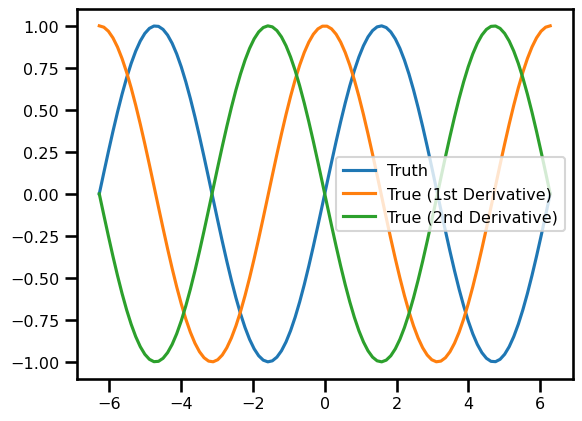

In [31]:
fig, ax = plt.subplots()

ax.plot(u_true.domain.coords, u_true[:], label="Truth")
ax.plot(du_dx_true.domain.coords, du_dx_true[:], label=f"True (1st Derivative)")
ax.plot(d2u_dx2_true.domain.coords, d2u_dx2_true[:], label=f"True (2nd Derivative)")

plt.legend()
plt.show()

### Finite Difference

**Assumption**: We do derivative operations on the same grid.

#### Operator API

In [32]:
from jaxsw._src.operators import difference as Op_diff

In [33]:
# initialize operator parameters
accuracy, derivative, method = 1, 1, "central"

# initialize operator
op_du_dx: tp.Callable = Op_diff.Difference(
    axis=0, accuracy=accuracy, derivative=derivative, method=method
)

# apply operator to field
du_dx: Field = op_du_dx(u_true.to_discrete_grid())

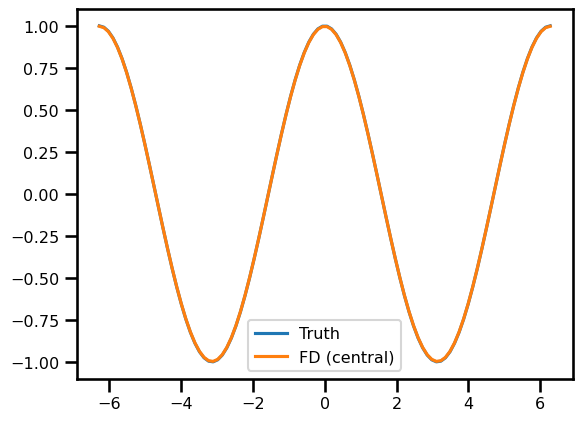

In [34]:
fig, ax = plt.subplots()

ax.plot(du_dx_true.domain.coords, du_dx_true[:], label="Truth")
ax.plot(du_dx.domain.coords, du_dx[:], label=f"FD ({method})")

plt.legend()
plt.show()

#### Functional API

In [18]:
# initialize operator parameters
accuracy, derivative, method = 1, 1, "central"

# apply functional API
du_dx = fdx.difference(
    u_true[:],
    step_size=u_true.domain.dx[0],
    axis=0,
    accuracy=accuracy,
    derivative=derivative,
    method=method,
)
du_dx.shape

(100,)

**Other APIs**


::::{tab-set}
:::{tab-item} JSOM API
:sync: tab1
```python
# define parameters
accuracy, derivative, method = 1, 1, "forward"

# our convenience function
du_dx: Array = F_diff.fv_difference(
    u_values, step_size=u.domain.dx[0], axis=0, 
    accuracy=accuracy, derivative=derivative, method=method
)
```
:::
:::{tab-item} Under The Hood
:sync: tab2
```python
# define parameters
accuracy, derivative, method = 1, 1, "forward"

# generate finite difference kernel
kernel: Array = F_diff.fd_kernel_init(
    step_size=u.domain.dx[0], axis=0, ndims=u.domain.ndim, 
    accuracy=accuracy, derivative=derivative, method=method
)

# apply convolution
du_dx: Array = F_diff.convolution(x: Array=u_values, kernel: Array=kernel)
```
:::
:::{tab-item} FiniteDiffX API
:sync: tab2
```python
# define parameters
accuracy, derivative, method = 1, 1, "forward"

# apply function
du_dx: Array = fdx.difference(
    u_values, step_size=u.domain.dx[0], axis=0, 
    accuracy=accuracy, derivative=derivative, method=method
)

# add finite volume correction
du_dx = du_dx[:-1]
```
:::
:::{tab-item} From scratch (Kernex)
:sync: tab2
```python
# define function
du_dx = (u_values[1:] - u_values[:-1]) /  u.domain.dx[0]
```
:::
:::{tab-item} From scratch (Kernex)
:sync: tab2
```python
import kernex as kex

# define function
def difference_1D_x(u: Array, step_size=1.0) -> Array:
        
    @kex.kmap(kernel_size=(2,), padding="valid")
    def kernel_fn(u):
        return u[1] - u[0]

    return kernel_fn(u) / step_size

# apply function
du_dx = difference_1D_x(u_values)
```
:::


::::

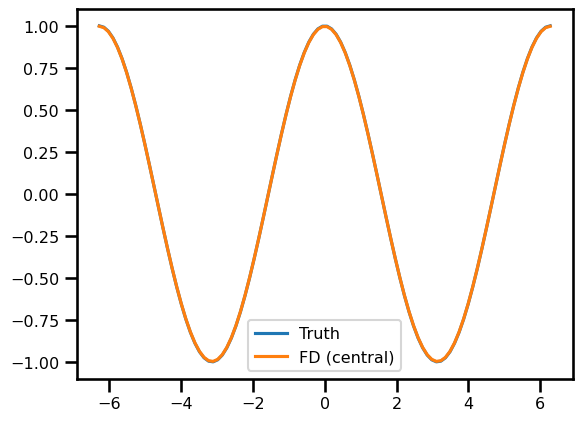

In [19]:
fig, ax = plt.subplots()

ax.plot(du_dx_true.domain.coords, du_dx_true[:], label="Truth")
ax.plot(du_dx_true.domain.coords, du_dx, label=f"FD ({method})")

plt.legend()
plt.show()

In [20]:
def check_num_dims(dx, ndim: int) -> tp.Tuple:
    if isinstance(dx, int) or isinstance(dx, float) or isinstance(dx, Array):
        return (dx,) * ndim
    elif isinstance(dx, list) or isinstance(dx, tuple):
        if len(dx) == 1:
            return tuple(dx) * ndim
        elif len(dx) == ndim:
            return tuple(dx)
        else:
            raise ValueError(f"Inconsistent length: {len(dx)} {ndim}")
    else:
        raise ValueError(f"Unrecognized type: {type(dx)}")

In [19]:
from jaxsw._src.operators.functional import arakawac
import equinox as eqx


class ArakawaCState(eqx.Module):
    u: Field
    h: Field

    def __init__(self, u: Field, h: Field):
        # pad everything
        # h: [Nx,Ny] --> [Nx+2,Ny+2]
        # u: [Nx,Ny] --> [Nx+3,Ny+2]
        self.u = u
        self.h = h

    @property
    def u_interior(self):
        return get_interior_1D(self.u)

    @property
    def h_interior(self):
        return get_interior_1D(self.h)


OPERATIONS = {
    "inner_half": (0.5, -0.5),
    "inner": (1.0, -1.0),
    "outer_half": (-0.5, 0.5),
    "outer": (-0.5, 0.5),
    "right_half": (0.5, 0.5),
    "right": (1.0, 1.0),
    "left_half": (-0.5, -0.5),
    "left": (-1.0, -1.0),
}


def limits_transform(
    xmin: tp.Tuple,
    xmax: tp.Tuple,
    dx: tp.Tuple,
    operations: tp.Optional[tp.Tuple] = None,
) -> tp.Tuple:
    msg = "Incorrect number of elements:\n"
    msg += f"{len(xmin)} | {len(xmax)} | {len(operations)}"
    assert len(xmin) == len(xmax) == len(operations), msg

    # correct dx
    dx = check_num_dims(dx, len(xmin))
    assert len(xmin) == len(dx)

    # TODO: check size of dx

    x_limits = [
        (xmin + idx * OPERATIONS[iop][0], xmax + idx * OPERATIONS[iop][1])
        if i is not None
        else (xmin, xmax)
        for i, (xmin, xmax, idx, iop) in enumerate(zip(xmin, xmax, dx, operations))
    ]
    xmin, xmax = zip(*x_limits)
    return xmin, xmax


def field_stagger_transform(u: Field, operation) -> Field:
    return u


def get_interior_1D(u: Field):
    # get interior values
    u_values = u[1:-1]

    xmin, xmax = limits_transform(
        u.domain.xmin, u.domain.xmax, u.domain.dx, operations=("inner",)
    )

    domain = Domain(xmin=xmin, xmax=xmax, dx=u.domain.dx)

    return Field(values=u_values, domain=domain)


def get_interior_2D_x(u: Field):
    # get interior values
    u_values = u[1:-1]

    xmin, xmax = limits_transform(
        u.domain.xmin, u.domain.xmax, u.domain.dx, operations=("inner", None)
    )

    domain = Domain(xmin=xmin, xmax=xmax, dx=u.domain.dx)

    return Field(values=u_values, domain=domain)


def get_interior_2D_y(u: Field):
    # get interior values
    u_values = u[:, 1:-1]

    xmin, xmax = limits_transform(
        u.domain.xmin, u.domain.xmax, u.domain.dx, operations=(None, "inner")
    )

    domain = Domain(xmin=xmin, xmax=xmax, dx=u.domain.dx)

    return Field(values=u_values, domain=domain)


def get_interior_2D_xy(u: Field):
    # get interior values
    u_values = u[1:-1, 1:-1]

    xmin, xmax = limits_transform(
        u.domain.xmin, u.domain.xmax, u.domain.dx, operations=("inner", "inner")
    )

    domain = Domain(xmin=xmin, xmax=xmax, dx=u.domain.dx)

    return Field(values=u_values, domain=domain)


class ArakawaCOperator(eqx.Module):
    def diffx(self, u: Field) -> Field:
        # calculate 1st derivative midpoint
        u_values = arakawac.diffx_midpoint(u=u[:], step_size=u.domain.dx[0])

        # Domain Change: [Nx, Ny] -> [Nx-1,Ny]
        # Limits Change: (xmin,xmax) -> (xmin+0.5, xmax-0.5)
        xmin, xmax = limits_transform(
            u.domain.xmin, u.domain.xmax, u.domain.dx, operations=("inner_half",)
        )

        domain = Domain(xmin=xmin, xmax=xmax, dx=u.domain.dx)

        return Field(values=u_values, domain=domain)

    def diffx2(self, u: Field) -> Field:
        # calculate 2nd derivative centerpoint
        u_values = arakawac.diffx2_centerpoint(u=u[:], step_size=u.domain.dx[0])

        # Domain Change: [Nx, Ny] -> [Nx-2,Ny]
        # Limits Change: (xmin,xmax) -> (xmin+1, xmax-1)
        xmin, xmax = limits_transform(
            u.domain.xmin, u.domain.xmax, u.domain.dx, operations=("inner",)
        )

        return Field(
            values=u_values, domain=Domain(xmin=xmin, xmax=xmax, dx=u.domain.dx)
        )

    def x_average(self, u: Field):
        # calculate average
        u_values = arakawac.x_average(u)

        # Domain Change: [Nx, Ny] -> [Nx-1,Ny]
        # Limits Change: (xmin,xmax) -> (xmin+0.5, xmax-0.5)
        xmin, xmax = limits_transform(
            u.domain.xmin, u.domain.xmax, u.domain.dx, operations=("inner_half",)
        )

        domain = Domain(xmin=xmin, xmax=xmax, dx=u.domain.dx)

        return Field(values=u_values, domain=domain)

    def advection(self, state: ArakawaCState, tracer: Field):
        """Calculates the conservation of the advected tracer by the fluid flow.

        ∂[q]/∂t + ∇ . (uq) = 0

        Returns the divergence term i.e. ∇.(uq)
        """
        tracer_at_u = field_domain_transform(tracer, state.u)
        adv = self.diffx(tracer_at_u * state.u)

        return adv


def periodic_bc(u):
    return u

In [122]:
import functools as ft
from jaxtyping import Float, Array


class ScalerTransform(eqx.Module):
    xmin: Float[Array, "D"] = eqx.static_field()
    xmax: Float[Array, "D"] = eqx.static_field()
    shape: Float[Array, "D"] = eqx.static_field()

    def __init__(self, xmin, xmax, shape):
        self.xmin = jnp.array(xmin)
        self.xmax = jnp.array(xmax)
        self.shape = jnp.array(shape)

    @classmethod
    def init_from_field(cls, u: Field) -> ScalerTransform:
        xmin = jnp.array(u.domain.xmin, dtype=jnp.float64)
        xmax = jnp.array(u.domain.xmax, dtype=jnp.float64)
        xshape = jnp.array(u.domain.grid_axis.shape[1:], dtype=jnp.float64)
        return cls(xmin=xmin, xmax=xmax, shape=xshape)

    @classmethod
    def init_from_domain(cls, domain: Domain) -> ScalerTransform:
        xmin = jnp.asarray(domain.xmin, dtype=jnp.float64)
        xmax = jnp.asarray(domain.xmax, dtype=jnp.float64)
        xshape = jnp.asarray(domain.grid_axis.shape[1:], dtype=jnp.float64)
        return cls(xmin=xmin, xmax=xmax, shape=xshape)

    def transform(self, x: Float[Array, "D"]) -> Array:
        return scaler_affine_transform(
            x, xmin=self.xmin, xmax=self.xmax, shape=self.shape
        )

    @ft.partial(
        jax.vmap,
        in_axes=(
            None,
            0,
        ),
    )
    def batch_transform(self, x: Float[Array, "N D"]) -> Array:
        return self.transform(x)

    def inverse_transform(self, x: Float[Array, "D"]) -> Array:
        return scalar_affine_transform_inverse(
            x=x, xmin=self.xmin, xmax=self.xmax, shape=self.shape
        )

    @ft.partial(
        jax.vmap,
        in_axes=(
            None,
            0,
        ),
    )
    def batch_inverse_transform(self, x: Float[Array, "N D"]) -> Array:
        return self.inverse_transform(x)


class DomainTransform(eqx.Module):
    domain_1: ScalerTransform
    domain_2: ScalerTransform

    @classmethod
    def init_from_field(cls, u: Field, v: Field) -> ScalerTransform:
        domain_1 = ScalerTransform.init_from_field(u=u)
        domain_2 = ScalerTransform.init_from_field(u=v)
        return cls(domain_1=domain_1, domain_2=domain_2)

    def transform(self, x: Float[Array, "D"]) -> Array:
        x_scaled = self.domain_1.transform(x)
        return self.domain_2.inverse_transform(x_scaled)

    @ft.partial(
        jax.vmap,
        in_axes=(
            None,
            0,
        ),
    )
    def batch_transform(self, x: Float[Array, "N D"]) -> Array:
        return self.transform(x)

    def inverse_transform(self, x: Float[Array, "D"]) -> Array:
        x_scaled = self.domain_2.transform(x)
        return self.domain_1.inverse_transform(x_scaled)

    @ft.partial(
        jax.vmap,
        in_axes=(
            None,
            0,
        ),
    )
    def batch_inverse_transform(self, x: Float[Array, "N D"]) -> Array:
        return self.inverse_transform(x)


def scaler_affine_transform(
    x: Array, xmin: Array, xmax: Array, shape: Array = 1.0
) -> Array:
    return shape * ((x - xmin) / (xmax - xmin))


def scalar_affine_transform_inverse(x, xmin, xmax, shape: Array = 1.0):
    return (x * (xmax - xmin) + xmin) / shape


def field_domain_transform(
    u: Field, v: Field, order: int = 1, mode: str = "reflect", cval: float = 1.0
):
    transformer_clf = DomainTransform.init_from_field(u, v)

    # get query indices for new domain
    indexes = transformer_clf.batch_transform(v.domain.coords)

    # get new values
    interp_fn = lambda indexes: jax.scipy.ndimage.map_coordinates(
        u[:], indexes, order=order, mode=mode, cval=cval
    )
    u = jax.vmap(interp_fn)(indexes)
    print(u.shape, v.domain.Nx)

    u = jnp.reshape(u, newshape=v.domain.Nx)

    return Field(values=u, domain=v.domain)

In [123]:
q.domain.Nx

(6,)

In [40]:
ncols = 5

# initialize the Q domain
q_domain = Domain(xmin=(0,), xmax=(ncols,), dx=(1,))
values = q_domain.grid_axis[0]
q = Field(values, q_domain)


# initialize the u-velocity domain
u_domain = Domain(xmin=(-0.5,), xmax=(ncols,), dx=(1,), stagger=("right",))
values = u_domain.grid_axis[0]
u = Field(values, u_domain)

q.values.shape, u.values.shape

((6,), (7,))

In [41]:
q.values, u.values

(Array([0., 1., 2., 3., 4., 5.], dtype=float64),
 Array([0., 1., 2., 3., 4., 5., 6.], dtype=float64))

In [43]:
u_on_q = F_interp.field_domain_transform(u, q)
q, u_on_q

[0.] [5.5] [7.]
[0.] [5.] [6.]


(Field(values=f64[6], domain=Domain(xmin=(0.0,), xmax=(5.0,), dx=(1,))),
 Field(values=f64[6], domain=Domain(xmin=(0.0,), xmax=(5.0,), dx=(1,))))

In [44]:
fn = jax.jit(field_domain_transform)

u_on_q = fn(u, q)

NameError: name 'field_domain_transform' is not defined

In [133]:
u_on_q = fn(u, q)

In [128]:
u, q, u_on_q

(Field(values=f64[7], domain=Domain(xmin=(0.0,), xmax=(5.5,), dx=(1,))),
 Field(values=f64[6], domain=Domain(xmin=(0.0,), xmax=(5.0,), dx=(1,))),
 Field(values=f64[6], domain=Domain(xmin=(0.0,), xmax=(5.0,), dx=(1,))))

In [45]:
# initialize the Q domain
q_domain = Domain(xmin=(0,), xmax=(10,), dx=(1,))
values = q_domain.grid_axis[0]
q = Field(values, q_domain)


# initialize the u-velocity domain
u_domain = Domain(xmin=(0,), xmax=(11,), dx=(1,))
values = u_domain.grid_axis[0]
u = Field(values, u_domain)

q[:], u[:]

(Array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.], dtype=float64),
 Array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.],      dtype=float64))

In [46]:
q_on_u = F_interp.field_domain_transform(q, u)
q_on_u[:]

[0.] [10.] [11.]
[0.] [11.] [12.]


Array([ 0.        ,  1.00833333,  2.01666667,  3.025     ,  4.03333333,
        5.04166667,  6.05      ,  7.05833333,  8.06666667,  9.075     ,
       10.        ,  9.90833333], dtype=float64)

In [47]:
u_on_q = F_interp.field_domain_transform(u, q)
u_on_q[:]

[0.] [11.] [12.]
[0.] [10.] [11.]


Array([0.        , 0.99173554, 1.98347107, 2.97520661, 3.96694215,
       4.95867769, 5.95041322, 6.94214876, 7.9338843 , 8.92561983,
       9.91735537], dtype=float64)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


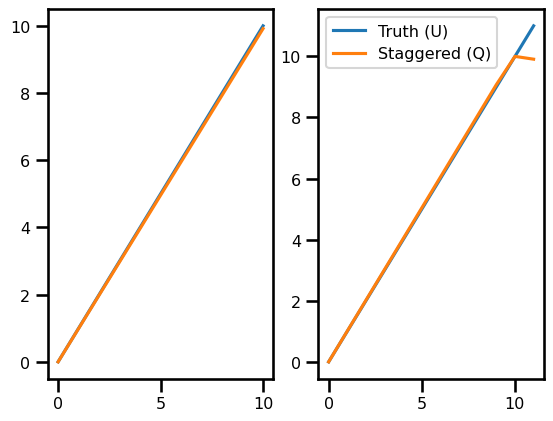

In [52]:
fig, ax = plt.subplots(ncols=2)

ax[0].plot(q.domain.coords, q[:], label="Truth (Q)")
ax[0].plot(u_on_q.domain.coords, u_on_q[:], label="Staggered (U)")

ax[1].plot(u.domain.coords, u[:], label="Truth (U)")
ax[1].plot(q_on_u.domain.coords, q_on_u[:], label="Staggered (Q)")

plt.legend()
plt.show()

```
u = [1, 5]
z_u = encode_u(u)
z_u = [0, 1]

v = [2, 4]
z_v = encode_u(v)
z_v = [0, 1]

v' = decode_
```

In [42]:
# initialize the Q domain
xmin, xmax = 0, 10
Nq, Nu = 5, 6
q_domain = Domain.from_numpoints(xmin=(xmin,), xmax=(xmax,), N=(Nq,))
values = q_domain.grid_axis[0]
q = Field(values, q_domain)


# initialize the u-velocity domain
u_domain = Domain.from_numpoints(
    xmin=(xmin - 1.0,), xmax=(xmax - 1.0,), N=(Nu,), stagger=("right",)
)
# u_domain = Domain.from_numpoints(xmin=(xmin+0.5,), xmax=(xmax+0.5,), N=(Nu,), stagger=("right",))
values = u_domain.grid_axis[0]
u = Field(values, u_domain)

q[:], q.domain.coords

(Array([ 0. ,  2.5,  5. ,  7.5, 10. ], dtype=float64),
 Array([[ 0. ],
        [ 2.5],
        [ 5. ],
        [ 7.5],
        [10. ]], dtype=float64))

In [43]:
u[:], u.domain.coords

(Array([ 0.,  2.,  4.,  6.,  8., 10.], dtype=float64),
 Array([[ 0.],
        [ 2.],
        [ 4.],
        [ 6.],
        [ 8.],
        [10.]], dtype=float64))

In [44]:
u_on_q = F_interp.field_domain_transform(u, q)
u_on_q[:], u_on_q.domain.coords

[0.] [10.] [5.]
[0.] [10.] [4.]
Coords Shape: (5, 1)
[[ 0. ]
 [ 2.5]
 [ 5. ]
 [ 7.5]
 [10. ]]
Indexes: [[0.]
 [1.]
 [2.]
 [3.]
 [4.]]


(Array([0., 2., 4., 6., 8.], dtype=float64),
 Array([[ 0. ],
        [ 2.5],
        [ 5. ],
        [ 7.5],
        [10. ]], dtype=float64))

In [45]:
q_on_u = F_interp.field_domain_transform(q, u)
q_on_u[:], q_on_u.domain.coords

[0.] [10.] [4.]
[0.] [10.] [5.]
Coords Shape: (6, 1)
[[ 0.]
 [ 2.]
 [ 4.]
 [ 6.]
 [ 8.]
 [10.]]
Indexes: [[0.]
 [1.]
 [2.]
 [3.]
 [4.]
 [5.]]


(Array([ 0. ,  2.5,  5. ,  7.5, 10. , 10. ], dtype=float64),
 Array([[ 0.],
        [ 2.],
        [ 4.],
        [ 6.],
        [ 8.],
        [10.]], dtype=float64))

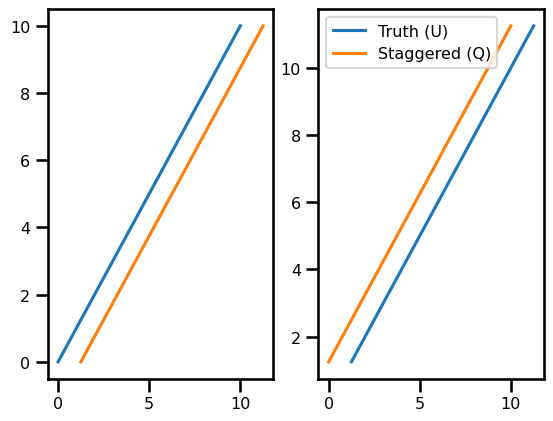

In [41]:
fig, ax = plt.subplots(ncols=2)

ax[0].plot(q.domain.coords, q[:], label="Truth (Q)")
ax[0].plot(q_on_u.domain.coords, q_on_u[:], label="Staggered (U)")

ax[1].plot(u.domain.coords, u[:], label="Truth (U)")
ax[1].plot(u_on_q.domain.coords, u_on_q[:], label="Staggered (Q)")

plt.legend()
plt.show()

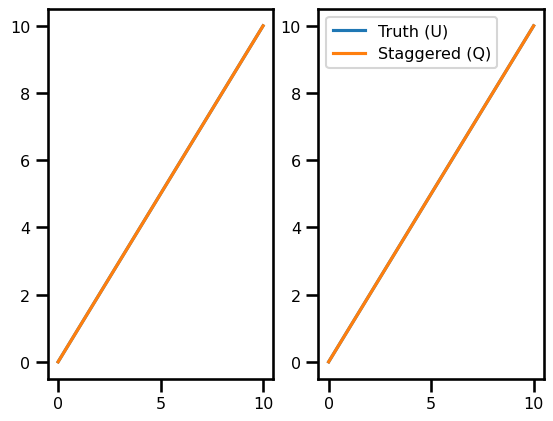

In [154]:
fig, ax = plt.subplots(ncols=2)

ax[0].plot(q.domain.coords, q[:], label="Truth (Q)")
ax[0].plot(u_on_q.domain.coords, u_on_q[:], label="Staggered (U)")

ax[1].plot(u.domain.coords, u[:], label="Truth (U)")
ax[1].plot(q_on_u.domain.coords, q_on_u[:], label="Staggered (Q)")

plt.legend()
plt.show()

In [29]:
ncols = 5

# initialize the Q domain
q_domain = Domain(xmin=(0,), xmax=(10,), dx=(1,))
values = q_domain.grid_axis[0]
q = Field(values, q_domain)


# initialize the u-velocity domain
u_domain = Domain(xmin=(2,), xmax=(8,), dx=(1,))
values = u_domain.grid_axis[0]
u = Field(values, u_domain)

q[:], u[:]

(Array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.], dtype=float64),
 Array([2., 3., 4., 5., 6., 7., 8.], dtype=float64))

In [30]:
q_on_u = F_interp.field_domain_transform(q, u)
q_on_u[:]

[0.] [10.] [11.]
[2.] [8.] [7.]


Array([3.88571429, 4.82857143, 5.77142857, 6.71428571, 7.65714286,
       8.6       , 9.54285714], dtype=float64)

In [19]:
fn_1 = lambda x: jax.scipy.ndimage.map_coordinates(q[:], x, order=1, mode="reflect")
fn_2 = lambda x: jax.scipy.ndimage.map_coordinates(u[:], x, order=1, mode="reflect")

In [17]:
domain1_t = F_interp.ScalerTransform.init_from_field(q)
domain2_t = F_interp.ScalerTransform.init_from_field(u)

[0.] [10.] [11.]
[2.] [8.] [7.]


(Array([11.], dtype=float64), Array([7.], dtype=float64))

In [22]:
x_1 = domain1_t.transform(jnp.array([10.0]))
x_2 = domain2_t.inverse_transform(x_1)
y_2 = fn_2(x_2)
x_1, x_2, y_2

(Array([11.], dtype=float64),
 Array([11.42857143], dtype=float64),
 Array(3.57142857, dtype=float64))

In [20]:
domain2_t.inverse_transform(out1), fn_1(domain2_t.inverse_transform(out1))

(Array([11.42857143], dtype=float64), Array(9.57142857, dtype=float64))

In [ ]:
domain1_t.inverse_transform(out2)

In [ ]:
tracer_at_u = field_domain_transform(tracer, state.u)

In [362]:
# initialize state
arakawa_state: eqx.Module = ArakawaCState(u=u, h=q)

arakawa_state.u, arakawa_state.h

(Field(values=f64[7], domain=Domain(xmin=(0.0,), xmax=(5.5,), dx=(1,))),
 Field(values=f64[6], domain=Domain(xmin=(0.0,), xmax=(5.0,), dx=(1,))))

In [363]:
# initialize operator
arakawa_op: eqx.Module = ArakawaCOperator()

**Grid Transformations**

**Example I**: Fluxes


* Velocities - `u[Nx+3,Nx+2]` --> `v[Nx+2,Nx+3]`
* Velocities - `v[Nx+2,Nx+3]` --> `u[Nx+3,Nx+2]`
* $\psi$ - `h[Nx+2,Nx+2]` --> `u[Nx+2,Nx+3]`
* $\psi$ - `h[Nx+2,Nx+2]` --> `v[Nx+2,Nx+3]`
* tracer, $q$ - `h[Nx+2,Nx+2]` --> `u[Nx+2,Nx+3]`
* tracer, $q$ - `h[Nx+2,Nx+2]` --> `v[Nx+2,Nx+3]`

In [364]:
du_dx = arakawa_op.diffx(arakawa_state.u)
d2u_dx2 = arakawa_op.diffx2(arakawa_state.u)
ubar = arakawa_op.x_average(arakawa_state.u)
adv = arakawa_op.advection(arakawa_state, arakawa_state.h)

arakawa_state.u, du_dx, d2u_dx2, ubar, adv

(Field(values=f64[7], domain=Domain(xmin=(0.0,), xmax=(5.5,), dx=(1,))),
 Field(values=f64[6], domain=Domain(xmin=(0.5,), xmax=(5.0,), dx=(1,))),
 Field(values=f64[5], domain=Domain(xmin=(1.0,), xmax=(4.5,), dx=(1,))),
 Field(values=f64[6], domain=Domain(xmin=(0.5,), xmax=(5.0,), dx=(1,))),
 Field(values=f64[6], domain=Domain(xmin=(0.5,), xmax=(5.0,), dx=(1,))))

In [366]:
arakawa_state.u[:], ubar[:]

(Array([0., 1., 2., 3., 4., 5., 6.], dtype=float64),
 Array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], dtype=float64))

In [289]:
x = jnp.array([0.0, 0.0])
x_min = jnp.array([0.0, 1.0])
x_max = jnp.array([5.0, 4.0])
y_min = jnp.array([1.0, 0.0])
y_max = jnp.array([4.0, 5.0])
x_shape = jnp.array([6.0, 4.0])
y_shape = jnp.array([4.0, 6.0])
scaler_new_domain(x, x_min, x_max, x_shape, y_min, y_max, y_shape)

Array([ 1.        , -1.11111111], dtype=float64)

**Linear Shallow Water**

```python
# ~~~ Linear Dynamics ~~~
ubarx = self.x_average(self._u)

# the height equation
phi_rhs  = - self.H*self.diffx(self.u)       # (nx) linear
phi_rhs += self.nu_phi*self.diff2x(self._phi)    # (nx) diffusion

# the u equation
dhdx = self.diffx(self._phi)         # (nx+2)
u_rhs  = -dhdx
u_rhs += self.nu*self.diff2x(self._u)
```


**Shallow Water Model**

```python
# ~~~ Nonlinear Dynamics ~~~
ubarx = self.x_average(self._u)

# the height equation
phi_at_u = self.x_average(self._phi)  # (nx+1)
phi_rhs  = - self.diffx(phi_at_u * self.u)       # (nx) nonlinear
#phi_rhs  = - self.diffx(np.mean(phi_at_u) * self.u)       # (nx) linear
phi_rhs += self.nu_phi*self.diff2x(self._phi)    # (nx) diffusion

# the u equation
dhdx = self.diffx(self._phi)         # (nx+2)
ududx = 0.5*self.diffx(ubarx**2)     # u*du/dx at u points

u_rhs  = -dhdx
u_rhs += self.nu*self.diff2x(self._u)
#u_rhs += - ududx                     # nonlin u advection terms
```

In [146]:
du_dx = arakawa_op.diffx(arakawa_state.u)
d2u_dx2 = arakawa_op.diffx2(arakawa_state.u)
ubar = arakawa_op.x_average(arakawa_state.u)
adv = arakawa_op.advection(arakawa_state, arakawa_state.h)

arakawa_state.u, du_dx, d2u_dx2, ubar, adv

Field(values=f64[6], domain=Domain(xmin=(0.0,), xmax=(5.0,), dx=(1,))) Field(values=f64[5], domain=Domain(xmin=(1.0,), xmax=(4.5,), dx=(1,)))
(6,) (5,)


AssertionError: Incorrect dimentions
Values: (6,) | Grid: (5,)

In [74]:
arakawa_state.u[:], du_dx[:], d2u_dx2[:]

(Array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], dtype=float64),
 Array([1., 1., 1., 1., 1.], dtype=float64),
 Array([0., 0., 0., 0.], dtype=float64))

### Finite Volume


```python
u: Field = ...
v: Field = ...
h: Field = ...
psi: Field = ...

# initialize difference operator
op_diff_u: Operator = FVDifference(u)
op_diff_v: Operator = FVDifference(v)
op_diff_h: Operator = FVDifference(h)
op_diff_psi: Operator = FVDifference(psi)

# calculate difference
du_dx: Field = op_diff_u.diffx(u)
du_dy: Field = op_diff_v.diffy(y)

# calculate 2nd difference
d2u_dx2: Field = op_diff_u.diffx2(u)
d2u_dy2: Field = op_diff_v.diffy2(y)

# calculate laplacian
u_lap: Field = op_diff_u.laplacian(u)

# interpolate u --> h
# domain transform from field
u_at_v: Field = field_interp(u, v, method="linear")

# change operators
du_dx: Field = op_diff_v.diffx(u_at_v)

```

In [280]:
import metpy.calc as mpcalc
from metpy.cbook import example_data

# load example data
ds = example_data()

In [281]:
dx = (
    np.max(ds.lat[1:].values - ds.lat[:-1].values),
    np.max(ds.lon[1:].values - ds.lon[:-1].values),
)
dx

(0.4347826086956559, 0.4347826086956843)

In [282]:
domain = Domain(
    xmin=(ds.lat.min().values, ds.lon.min().values),
    xmax=(
        ds.lat.max().values,
        ds.lon.max().values,
    ),
    dx=dx,
)
temperature = ds.temperature.values

h: Field = Field(values=temperature, domain=domain)

In [286]:
h.domain.coords_axis.shape, h.domain.grid_axis.shape

((2, 24), (2, 24, 24))

In [323]:
# class ArakawaCState:
#     u: Field
#     v: Field
#     h: Field





class ArakawaCGrid2D(eqx.Module):
    u: Field
    v: Field
    h: Field
    
    def __init__(self, u: Field, v: Field, h: Field):
        self.u = u
        self.v = v
        self.h = h

    def diffx(self, u: Field):
        return arakawac.diffx_midpoint(u=u[:], step_size=u.domain.dx[0])

    def diffy(self, u: Field, step_size: float=None):
        return arakawac.diffy_midpoint(u=u[:], step_size=u.domain.dx[1])

    def diffx2(self, u: Field, step_size: float=None):
        return arakawac.diffx2_centerpoint(u=u[:], step_size=u.domain.dx[0])
        
    def diffy2(self, u: Field, step_size: float=None):
        return arakawac.diffy2_centerpoint(u=u[:], step_size=u.domain.dx[1])
        
    def del2(self, u: Field, step_size: float=None):
        return arakawac.laplacian_centerpoint(u[:], step_size=u.domain.dx)

    @property
    def u_at_h(self):
        return x_average(self.values)

    @property
    def u_at_v(self):
        return y_average(self.values[1:-1)

    @property
    def v_at_h(self):
        return y_average(self.values)

    @property
    def v_at_u(self):
        return x_average(self.values)

    def divergence(self):
        pass
    def vorticity(self):
        pass
        

In [328]:
# Differences
dh_dx_ = diffx(h[:], h.domain.dx[0])
dh_dy_ = diffy(h[:], h.domain.dx[1])

op_fv_u: FVOperator = FVOperator(h)
dh_dx: Array = arakawac.diffx_midpoint(
    h[:],
)
dh_dy: Array = arakawac.diffy_midpoint(h)

np.testing.assert_array_almost_equal(dh_dx_, dh_dx)
np.testing.assert_array_almost_equal(dh_dy_, dh_dy)

TypeError: diffx_midpoint() missing 1 required positional argument: 'step_size'

In [326]:
# 2nd Order Differences
d2h_dx2_ = diffx2(h[:], h.domain.dx[0])
d2h_dy2_ = diffy2(h[:], h.domain.dx[1])


d2h_dx2: Array = arakawac.diffx2(h)
d2h_dy2: Array = arakawac.diffy2(h)

np.testing.assert_array_almost_equal(d2h_dx2_, d2h_dx2)
np.testing.assert_array_almost_equal(d2h_dy2_, d2h_dy2)

In [309]:
#


del2_u_ = del2(h[:], h.domain.dx)

# our API

del2_h: Array = arakawac.del2(h)

np.testing.assert_array_almost_equal(del2_u_, del2_h)

In [253]:
du_dx

Array([ 0.87102642,  0.21512576, -0.60276898, -0.96676639, -0.60276898,
        0.21512576,  0.87102642,  0.87102642,  0.21512576, -0.60276898,
       -0.96676639, -0.60276898,  0.21512576,  0.87102642], dtype=float64)

In [174]:
du_dx_

Array([ 0.87102642,  0.21512576, -0.60276898, -0.96676639, -0.60276898,
        0.21512576,  0.87102642,  0.87102642,  0.21512576, -0.60276898,
       -0.96676639, -0.60276898,  0.21512576,  0.87102642], dtype=float64)

#### Operator API

In [80]:
new_domain.grid_axis.shape

(1, 14)

In [167]:
# initialize operator parameters
accuracy, derivative, method = 1, 1, "forward"

# apply functional API on values
du_dx = F_diff.fv_difference(
    u_true[:],
    step_size=u_true.domain.dx[0],
    axis=0,
    accuracy=accuracy,
    derivative=derivative,
    method=method,
)
u_true[:].shape, du_dx.shape, stagger + (accuracy + derivative)

((15,), (14,), 2.5)

2.0

In [168]:
accuracy, derivative, method = 1, 2, "forward"
stagger = 0.5
offsets = fdx._src.utils._generate_forward_offsets(derivative, accuracy)
offsets, (offsets[0] + stagger, offsets[-1] - stagger)

((0, 1, 2), (0.5, 1.5))

In [127]:
accuracy, derivative, method = 2, 1, "central"
stagger = 0.5
left = derivative + accuracy
right = derivative + accuracy
(left, right), (left + stagger, right - stagger)

((3, 3), (3.5, 2.5))

#### Functional API

In [90]:
# apply functional API on values
du_dx = F_diff.fv_difference(
    u_true[:],
    step_size=u_true.domain.dx[0],
    axis=0,
    accuracy=accuracy,
    derivative=derivative,
    method=method,
)
# change API based on difference
new_domain = domain_stagger(u_true.domain, axis=0, operation=method)
print(du_dx.shape, new_domain.Nx)

#
du_dx = Field(values=du_dx, domain=new_domain)

0.8975979010256552
0.4487989505128276
(13,) (14,)


AssertionError: 

In [61]:
from jaxsw._src.operators.functional.domain import limits_stagger, domain_stagger

**Other APIs**


::::{tab-set}
:::{tab-item} JSOM API
:sync: tab1
```python
# define parameters
accuracy, derivative, method = 1, 1, "forward"

# our convenience function
du_dx: Array = F_diff.fv_difference(
    u_values, step_size=u.domain.dx[0], axis=0, 
    accuracy=accuracy, derivative=derivative, method=method
)
```
:::
:::{tab-item} Under The Hood
:sync: tab2
```python
# define parameters
accuracy, derivative, method = 1, 1, "forward"

# generate finite difference kernel
kernel: Array = F_diff.fd_kernel_init(
    step_size=u.domain.dx[0], axis=0, ndims=u.domain.ndim, 
    accuracy=accuracy, derivative=derivative, method=method
)

# apply convolution
du_dx: Array = F_diff.convolution(x: Array=u_values, kernel: Array=kernel)
```
:::
:::{tab-item} FiniteDiffX API
:sync: tab2
```python
# define parameters
accuracy, derivative, method = 1, 1, "forward"

# apply function
du_dx: Array = fdx.difference(
    u_values, step_size=u.domain.dx[0], axis=0, 
    accuracy=accuracy, derivative=derivative, method=method
)

# add finite volume correction
du_dx = du_dx[:-1]
```
:::
:::{tab-item} From scratch (Kernex)
:sync: tab2
```python
# define function
du_dx = (u_values[1:] - u_values[:-1]) /  u.domain.dx[0]
```
:::
:::{tab-item} From scratch (Kernex)
:sync: tab2
```python
import kernex as kex

# define function
def difference_1D_x(u: Array, step_size=1.0) -> Array:
        
    @kex.kmap(kernel_size=(2,), padding="valid")
    def kernel_fn(u):
        return u[1] - u[0]

    return kernel_fn(u) / step_size

# apply function
du_dx = difference_1D_x(u_values)
```
:::


::::

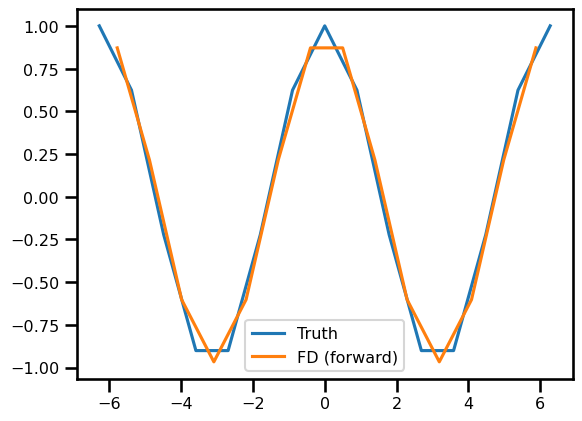

In [23]:
fig, ax = plt.subplots()

ax.plot(du_dx_true.domain.coords, du_dx_true[:], label="Truth")
ax.plot(du_dx_true.domain.coords[:-1] + 0.5, du_dx, label=f"FD ({method})")

plt.legend()
plt.show()

### Padding

You may notice that it's a bit awkward to have to move the velocities on top of the q values.
We are missing one on the left.
We can fix this by padding the u vector before we perform the operation

In [139]:
u_vals = 5 + u.values
u_pad = jnp.pad(u_vals, pad_width=((1, 0)), mode="edge")

# u_pad = jnp.pad(u_vals, pad_width=((1, 0)), mode="constant", constant_values=(u_vals[0]))
u.values, u_pad

(Array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], dtype=float64),
 Array([ 5.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5], dtype=float64))

In [140]:
-u_pad[:-1] + u_pad[1:]

Array([0., 1., 1., 1., 1., 1.], dtype=float64)

In [143]:
np.gradient(u_pad, axis=0, edge_order=1)

array([0. , 0.5, 1. , 1. , 1. , 1. , 1. ])

In [144]:
u_pad[1:] - u_pad[:-1]

Array([0., 1., 1., 1., 1., 1.], dtype=float64)

In [145]:
F_grid.difference(u_pad, step_size=1, axis=0, method="right")

Array([0., 1., 1., 1., 1., 1.], dtype=float64)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


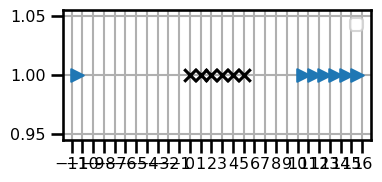

In [82]:
fig, ax = plt.subplots(figsize=(4, 2))

ax.scatter(q.values, jnp.ones_like(q.values), marker="x", color="black", zorder=2)
ax.scatter(u_pad, jnp.ones_like(u_pad), marker=">", color="tab:blue", zorder=2)
ax.xaxis.set_major_locator(MultipleLocator(1))

# ax.set(xlim=[-1.5, ncols + 1.0])
ax.grid(which="major", zorder=1)
plt.legend()
plt.tight_layout()
plt.show()

In [78]:
u_on_q = F_grid.interp(u_pad, axis=0, method="linear")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


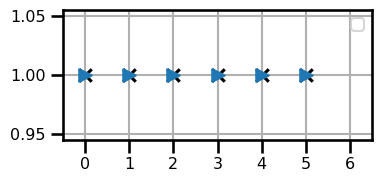

In [79]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(4, 2))

ax.scatter(q.values, jnp.ones_like(q.values), marker="x", color="black", zorder=2)
ax.scatter(u_on_q, np.ones_like(u_on_q), marker=">", color="tab:blue", zorder=2)
ax.xaxis.set_major_locator(MultipleLocator(1))

ax.set(xlim=[-0.5, ncols + 1.5])
ax.grid(which="major", zorder=1)
plt.legend()
plt.tight_layout()
plt.show()

In [130]:
# High-Level API (automatic)
du_dx = F_diff.fv_difference(
    u_values,
    step_size=dx,
    axis=0,
    method="forward",
    derivative=1,
    accuracy=1,
)
du_dx.shape

(19,)

**Other APIs**


::::{tab-set}
:::{tab-item} JSOM API
:sync: tab1
```python
# define parameters
accuracy, derivative, method = 1, 1, "forward"

# our convenience function
du_dx: Array = F_diff.fv_difference(
    u_values, step_size=u.domain.dx[0], axis=0, 
    accuracy=accuracy, derivative=derivative, method=method
)
```
:::
:::{tab-item} Under The Hood
:sync: tab2
```python
# define parameters
accuracy, derivative, method = 1, 1, "forward"

# generate finite difference kernel
kernel: Array = F_diff.fd_kernel_init(
    step_size=u.domain.dx[0], axis=0, ndims=u.domain.ndim, 
    accuracy=accuracy, derivative=derivative, method=method
)

# apply convolution
du_dx: Array = F_diff.convolution(x: Array=u_values, kernel: Array=kernel)
```
:::
:::{tab-item} FiniteDiffX API
:sync: tab2
```python
# define parameters
accuracy, derivative, method = 1, 1, "forward"

# apply function
du_dx: Array = fdx.difference(
    u_values, step_size=u.domain.dx[0], axis=0, 
    accuracy=accuracy, derivative=derivative, method=method
)

# add finite volume correction
du_dx = du_dx[:-1]
```
:::
:::{tab-item} From scratch (Kernex)
:sync: tab2
```python
# define function
du_dx = (u_values[1:] - u_values[:-1]) /  u.domain.dx[0]
```
:::
:::{tab-item} From scratch (Kernex)
:sync: tab2
```python
import kernex as kex

# define function
def difference_1D_x(u: Array, step_size=1.0) -> Array:
        
    @kex.kmap(kernel_size=(2,), padding="valid")
    def kernel_fn(u):
        return u[1] - u[0]

    return kernel_fn(u) / step_size

# apply function
du_dx = difference_1D_x(u_values)
```
:::


::::

In [126]:
# define parameters
accuracy, derivative, method = 1, 1, "forward"

# apply function
du_dx: Array = fdx.difference(
    u_values,
    step_size=dx,
    axis=0,
    accuracy=accuracy,
    derivative=derivative,
    method=method,
)

# add finite volume correction
# du_dx = du_dx

ValueError: x and y must have same first dimension, but have shapes (20,) and (19,)

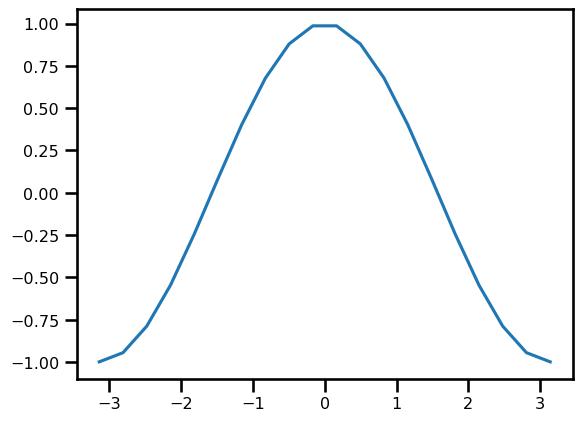

In [131]:
fig, ax = plt.subplots()

ax.plot(x_values, du_values, label="Truth")
ax.plot(x_values + (dx * 0.5), du_dx, label="FV")

plt.legend()
plt.show()

In [239]:
# High-Level API (automatic)
d2u_dx2_hi = F_grid.difference(
    u_values, step_size=u.domain.dx[0], axis=0, method="forward", derivative=2
)
u_values.shape, d2u_dx2_hi.shape

((50,), (48,))

**Mid-Level API**: Convenience Functions

In [240]:
# Mid-Level API (external library)
d2u_dx2_mid_fdx = fdx.difference(
    u_values, step_size=u.domain.dx[0], axis=0, derivative=2, method="forward"
)[:-2]
d2u_dx2_mid_fdx.shape

(48,)

**Low-Level API**: From Scratch

In [241]:
# Low-Level API (from scratch)
d2u_dx2_lo = (u_values[2:] - 2 * u_values[1:-1] + u_values[:-2]) / u.domain.dx[0] ** 2
u_values.shape, du_dx_lo.shape

((50,), (49,))

**Low-Level API:** Alternative Functions

In [242]:
# Low-Level API (kernex)
def difference_1D_x(
    u: Array, step_size=1.0, padding: tp.Optional[tp.Tuple] = "valid"
) -> Array:
    @kex.kmap(kernel_size=(3,), padding=padding)
    def kernel_fn(u):
        return u[2] - 2 * u[1] + u[0]

    return kernel_fn(u) / step_size**2


d2u_dx2_kernex = difference_1D_x(u_values)
d2u_dx2_kernex

Array([-0.01659162, -0.03209797, -0.04550479, -0.05593512, -0.06270673,
       -0.06537667, -0.0637703 , -0.0579927 , -0.04842179, -0.03568359,
       -0.02061131, -0.00419085,  0.01250374,  0.02838045,  0.0424008 ,
        0.05364769,  0.06138548,  0.06510802,  0.06457183,  0.05981198,
        0.05113981,  0.03912257,  0.02454632,  0.00836448, -0.00836448,
       -0.02454632, -0.03912257, -0.05113981, -0.05981198, -0.06457183,
       -0.06510802, -0.06138548, -0.05364769, -0.0424008 , -0.02838045,
       -0.01250374,  0.00419085,  0.02061131,  0.03568359,  0.04842179,
        0.0579927 ,  0.0637703 ,  0.06537667,  0.06270673,  0.05593512,
        0.04550479,  0.03209797,  0.01659162], dtype=float64)

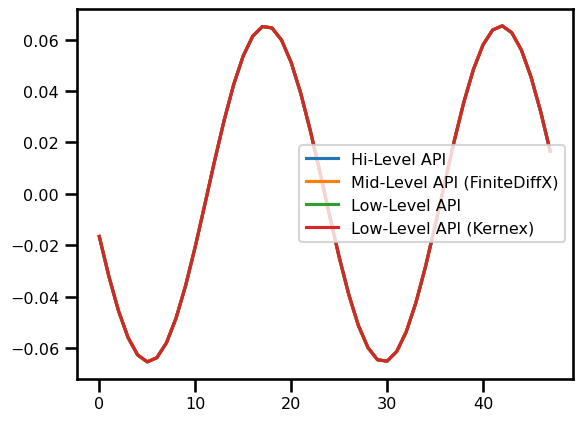

In [243]:
fig, ax = plt.subplots()

# ax.plot(u_values, label="Truth")
ax.plot(d2u_dx2_hi, label="Hi-Level API")
ax.plot(d2u_dx2_mid_fdx, label="Mid-Level API (FiniteDiffX)")
ax.plot(d2u_dx2_lo, label="Low-Level API")
ax.plot(d2u_dx2_kernex, label="Low-Level API (Kernex)")

plt.legend()
plt.show()

In [75]:
u_on_q_hi.values, u_on_q_mid, u_on_q_kernex, u_on_q_lo

(Array([1., 1., 2., 3., 4., 5.], dtype=float64),
 Array([1., 2., 3., 4., 5.], dtype=float64),
 Array([1., 2., 3., 4., 5.], dtype=float64),
 Array([1., 2., 3., 4., 5.], dtype=float64))

In [82]:
# Low-Level (From Scratch)
dq_dx = F_grid.difference(
    q.values,
)
dq_dx.shape, q.shape

((5,), (6,))

### Nodes to Edges

This happens when we want to move the field defined on the field to the top-down edges.
For example, we may want to use the quantity of interest defined on the nodes to estimate the velocities defined on the top-down edges.

## 2D Grid

In [36]:
n_rows = 3
n_cols = 5

# Stream Function Domain - Cell Corners
psi_domain = Domain(xmin=(0, 0), xmax=(n_rows, n_cols), dx=(1, 1))
psi_x = Field(psi_domain.grid[..., 0], psi_domain)
psi_y = Field(psi_domain.grid[..., 1], psi_domain)

# Q Domain - cell faces
q_domain = Domain(
    xmin=(0.0, 0.0), xmax=(n_rows, n_cols), dx=(1, 1), stagger=("right", "right")
)
q_x = Field(q_domain.grid[..., 0], q_domain)
q_y = Field(q_domain.grid[..., 1], q_domain)

In [37]:
psi_x.values

Array([[0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1.],
       [2., 2., 2., 2., 2., 2.],
       [3., 3., 3., 3., 3., 3.]], dtype=float64)

In [38]:
psi_x_on_q_x = fv.interp.domain_transformation(psi_x, q_x, mode="reflect")
psi_x_on_q_x.values, q_x.values

(Array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
        [1.5, 1.5, 1.5, 1.5, 1.5, 1.5],
        [2.5, 2.5, 2.5, 2.5, 2.5, 2.5],
        [2.5, 2.5, 2.5, 2.5, 2.5, 2.5]], dtype=float64),
 Array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
        [1.5, 1.5, 1.5, 1.5, 1.5, 1.5],
        [2.5, 2.5, 2.5, 2.5, 2.5, 2.5],
        [3.5, 3.5, 3.5, 3.5, 3.5, 3.5]], dtype=float64))

In [26]:
psi_x_on_q_x, q_x.values

(Field(
   values=f64[4,6],
   domain=Domain(xmin=(0.5, 0.5), xmax=(3.5, 5.5), dx=(1, 1))
 ),
 Array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
        [1.5, 1.5, 1.5, 1.5, 1.5, 1.5],
        [2.5, 2.5, 2.5, 2.5, 2.5, 2.5],
        [3.5, 3.5, 3.5, 3.5, 3.5, 3.5]], dtype=float64))

## 2D Arakawa C-Grid

In this example, we will look at the classic Arakawa C-Grid.
This seems to be the standard for using standard finite difference methods on gridded domains.
All of the variables are on staggered domains which means that we will have to do some small transformations to put each variable on other domains.

In this example, we'll look at two variables along with their corresponding velocities.
The inspiration comes from the QG equation where we have

$$
\begin{aligned}
\partial_t q + \vec{u}\cdot q &= 0 \\
q = \boldsymbol{\nabla}_H \psi
\end{aligned}
$$

where we have four variables we need to handle in total:

* $q$ - potential vorticity on the cell faces
* $u$ - zonal velocity on the Top-Bottom cell edges
* $v$ - meridional velocity on the East-West cell edges
* $\psi$ - stream function on the cell nodes.

### Interpolation

In [ ]:
n_rows = 3
n_cols = 5

# Stream Function Domain - Cell Corners
psi_domain = Domain(xmin=(0, 0), xmax=(n_rows, n_cols), dx=(1, 1))
psi_x = Field(psi_domain.grid[..., 0], psi_domain)
psi_y = Field(psi_domain.grid[..., 1], psi_domain)

# Q Domain - cell faces
q_domain = Domain(
    xmin=(0.0, 0.0), xmax=(n_rows, n_cols), dx=(1, 1), stagger=("right", "right")
)
q_x = Field(q_domain.grid[..., 0], q_domain)
q_y = Field(q_domain.grid[..., 1], q_domain)

# U Velocity -
u_domain = Domain(
    xmin=(0, 0), xmax=(n_rows, n_cols), dx=(1, 1), stagger=("right", None)
)
u_x = Field(u_domain.grid[..., 0], u_domain)
u_y = Field(u_domain.grid[..., 1], u_domain)

# V Velocity
v_domain = Domain(
    xmin=(0, 0), xmax=(n_rows, n_cols), dx=(1, 1), stagger=(None, "right")
)
v_x = Field(v_domain.grid[..., 0], v_domain)
v_y = Field(v_domain.grid[..., 1], v_domain)

In [34]:
n_rows = 3
n_cols = 5

# Stream Function Domain - Cell Corners
psi_domain = Domain(xmin=(0, 0), xmax=(n_rows, n_cols), dx=(1, 1))
psi_x = Field(psi_domain.grid[..., 0], psi_domain)
psi_y = Field(psi_domain.grid[..., 1], psi_domain)

# Q Domain - cell faces
q_domain = Domain(
    xmin=(0.0, 0.0), xmax=(n_rows, n_cols), dx=(1, 1), stagger=("right", "right")
)
q_x = Field(q_domain.grid[..., 0], q_domain)
q_y = Field(q_domain.grid[..., 1], q_domain)

# U Velocity -
u_domain = Domain(
    xmin=(0, 0), xmax=(n_rows, n_cols), dx=(1, 1), stagger=("right", None)
)
u_x = Field(u_domain.grid[..., 0], u_domain)
u_y = Field(u_domain.grid[..., 1], u_domain)

# V Velocity
v_domain = Domain(
    xmin=(0, 0), xmax=(n_rows, n_cols), dx=(1, 1), stagger=(None, "right")
)
v_x = Field(v_domain.grid[..., 0], v_domain)
v_y = Field(v_domain.grid[..., 1], v_domain)


# # initialize the Q domain
# q_domain = Domain(xmin=(0,), xmax=(ncols,), dx=(1,))
# values = q_domain.grid
# q = Field(values, q_domain)


# # initialize the u-velocity domain
# u_domain = Domain(xmin=(0,), xmax=(ncols,), dx=(1,), stagger=("right",))
# values = u_domain.grid
# u = Field(values, u_domain)
psi_x.values.shape

(4, 6)

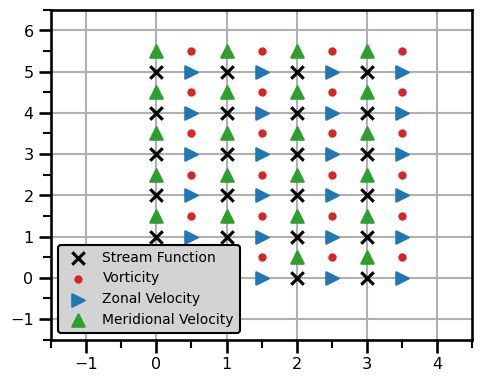

In [35]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(
    psi_x.values.ravel(),
    psi_y.values.ravel(),
    marker="x",
    color="black",
    zorder=2,
    label="Stream Function",
)
ax.scatter(
    q_x.values.ravel(),
    q_y.values.ravel(),
    marker=".",
    color="tab:red",
    zorder=2,
    label="Vorticity",
)
ax.scatter(
    u_x.values.ravel(),
    u_y.values.ravel(),
    marker=">",
    color="tab:blue",
    zorder=2,
    label="Zonal Velocity",
)
ax.scatter(
    v_x.values.ravel(),
    v_y.values.ravel(),
    marker="^",
    color="tab:green",
    zorder=2,
    label="Meridional Velocity",
)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.set(xlim=[-1.5, n_rows + 1.5], ylim=[-1.5, n_cols + 1.5])
ax.grid(
    which="major",
    zorder=1,
)
plt.legend(fontsize=10, edgecolor="black", framealpha=1.0, facecolor="lightgray")
plt.tight_layout()
plt.show()

This example seems quite complicated and possibly unnecessary because we have two variables and the velocities.
This can occur in the contrived example but in many cases, we may only have 1 variable and the velocities, e.g. Shallow Water equations.
In this case, we have some options, we can use the cell faces as the main variable or the cell nodes.
It's up to us. 

### Transformations to Variable

In this first case, we will look at all transformations that can get us to the vorticity from any other variable on this grid.

$$
\begin{aligned}
\psi &\rightarrow q \\
u &\rightarrow q \\
v &\rightarrow q
\end{aligned}
$$

In [ ]:
jnp.ge(

In [14]:
u_x_on_q = F_grid.grid_operator(u_x, (None, "right"))
u_y_on_q = F_grid.grid_operator(u_y, (None, "right"))

v_x_on_q = F_grid.grid_operator(v_x, ("right", None))
v_y_on_q = F_grid.grid_operator(v_y, ("right", None))

psi_x_on_q = F_grid.grid_operator(psi_x, ("right", "right"))
psi_y_on_q = F_grid.grid_operator(psi_y, ("right", "right"))

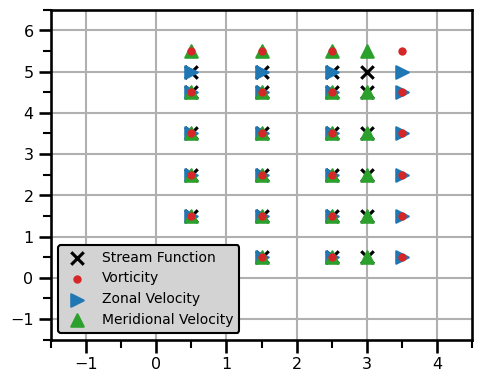

In [15]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(
    psi_x_on_q.values.ravel(),
    psi_y_on_q.values.ravel(),
    marker="x",
    color="black",
    zorder=2,
    label="Stream Function",
)
ax.scatter(
    q_x.values.ravel(),
    q_y.values.ravel(),
    marker=".",
    color="tab:red",
    zorder=3,
    label="Vorticity",
)
ax.scatter(
    u_x_on_q.values.ravel(),
    u_y_on_q.values.ravel(),
    marker=">",
    color="tab:blue",
    zorder=2,
    label="Zonal Velocity",
)
ax.scatter(
    v_x_on_q.values.ravel(),
    v_y_on_q.values.ravel(),
    marker="^",
    color="tab:green",
    zorder=2,
    label="Meridional Velocity",
)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.set(xlim=[-1.5, n_rows + 1.5], ylim=[-1.5, n_cols + 1.5])
ax.grid(
    which="major",
    zorder=1,
)
plt.legend(fontsize=10, edgecolor="black", framealpha=1.0, facecolor="lightgray")
plt.tight_layout()
plt.show()

### Transforms to PSI Variable

In this first case, we will look at all transformations that can get us to the vorticity from any other variable on this grid.

$$
\begin{aligned}
q &\rightarrow \psi \\
u &\rightarrow \psi \\
v &\rightarrow \psi
\end{aligned}
$$

In [36]:
u_x_on_psi = F_grid.grid_operator(u_x, ("left", None))
u_y_on_psi = F_grid.grid_operator(u_y, ("left", None))

v_x_on_psi = F_grid.grid_operator(v_x, (None, "left"))
v_y_on_psi = F_grid.grid_operator(v_y, (None, "left"))

q_x_on_psi = F_grid.grid_operator(q_x, ("left", "left"))
q_y_on_psi = F_grid.grid_operator(q_y, ("left", "left"))

In [39]:
u_x_on_psi, u_x

(Field(
   values=f64[4,6],
   domain=Domain(xmin=(0.0, 0.0), xmax=(3.0, 5.0), dx=(1, 1))
 ),
 Field(
   values=f64[4,6],
   domain=Domain(xmin=(0.5, 0.0), xmax=(3.5, 5.0), dx=(1, 1))
 ))

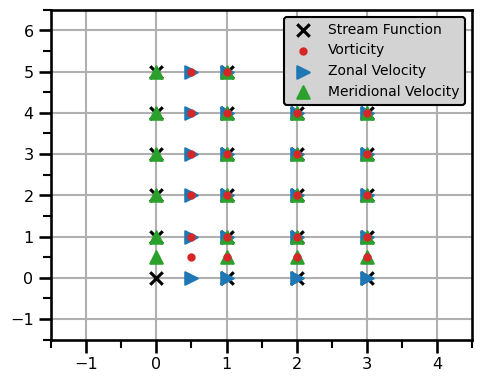

In [37]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(
    psi_x.values.ravel(),
    psi_y.values.ravel(),
    marker="x",
    color="black",
    zorder=2,
    label="Stream Function",
)
ax.scatter(
    q_x_on_psi.values.ravel(),
    q_y_on_psi.values.ravel(),
    marker=".",
    color="tab:red",
    zorder=3,
    label="Vorticity",
)
ax.scatter(
    u_x_on_psi.values.ravel(),
    u_y_on_psi.values.ravel(),
    marker=">",
    color="tab:blue",
    zorder=2,
    label="Zonal Velocity",
)
ax.scatter(
    v_x_on_psi.values.ravel(),
    v_y_on_psi.values.ravel(),
    marker="^",
    color="tab:green",
    zorder=2,
    label="Meridional Velocity",
)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.set(xlim=[-1.5, n_rows + 1.5], ylim=[-1.5, n_cols + 1.5])
ax.grid(
    which="major",
    zorder=1,
)
plt.legend(fontsize=10, edgecolor="black", framealpha=1.0, facecolor="lightgray")
plt.tight_layout()
plt.show()

### Transforms to U-Velocity

In this first case, we will look at all transformations that can get us to the u-velocity from any other variable on this grid.

$$
\begin{aligned}
q &\rightarrow u \\
\psi &\rightarrow u \\
v &\rightarrow u
\end{aligned}
$$

In [18]:
psi_x_on_u = F_grid.grid_operator(psi_x, ("right", None))
psi_y_on_u = F_grid.grid_operator(psi_y, ("right", None))

v_x_on_u = F_grid.grid_operator(v_x, ("right", "left"))
v_y_on_u = F_grid.grid_operator(v_y, ("right", "left"))

q_x_on_u = F_grid.grid_operator(q_x, (None, "left"))
q_y_on_u = F_grid.grid_operator(q_y, (None, "left"))

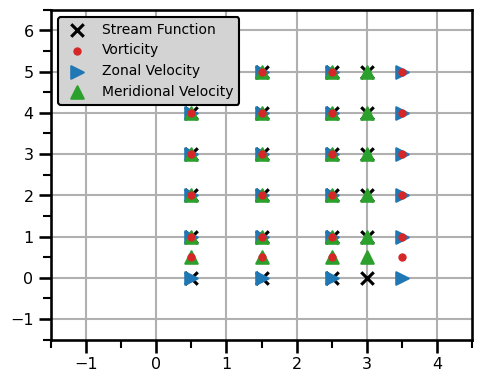

In [19]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(
    psi_x_on_u.values.ravel(),
    psi_y_on_u.values.ravel(),
    marker="x",
    color="black",
    zorder=2,
    label="Stream Function",
)
ax.scatter(
    q_x_on_u.values.ravel(),
    q_y_on_u.values.ravel(),
    marker=".",
    color="tab:red",
    zorder=3,
    label="Vorticity",
)
ax.scatter(
    u_x.values.ravel(),
    u_y.values.ravel(),
    marker=">",
    color="tab:blue",
    zorder=2,
    label="Zonal Velocity",
)
ax.scatter(
    v_x_on_u.values.ravel(),
    v_y_on_u.values.ravel(),
    marker="^",
    color="tab:green",
    zorder=2,
    label="Meridional Velocity",
)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.set(xlim=[-1.5, n_rows + 1.5], ylim=[-1.5, n_cols + 1.5])
ax.grid(
    which="major",
    zorder=1,
)
plt.legend(fontsize=10, edgecolor="black", framealpha=1.0, facecolor="lightgray")
plt.tight_layout()
plt.show()

### Transforms to V-Velocity

In this first case, we will look at all transformations that can get us to the v-velocity from any other variable on this grid.

$$
\begin{aligned}
q &\rightarrow v \\
\psi &\rightarrow v \\
u &\rightarrow v
\end{aligned}
$$

In [20]:
psi_x_on_v = F_grid.grid_operator(psi_x, (None, "right"))
psi_y_on_v = F_grid.grid_operator(psi_y, (None, "right"))

u_x_on_v = F_grid.grid_operator(u_x, ("left", "right"))
u_y_on_v = F_grid.grid_operator(u_y, ("left", "right"))

q_x_on_v = F_grid.grid_operator(q_x, ("left", None))
q_y_on_v = F_grid.grid_operator(q_y, ("left", None))

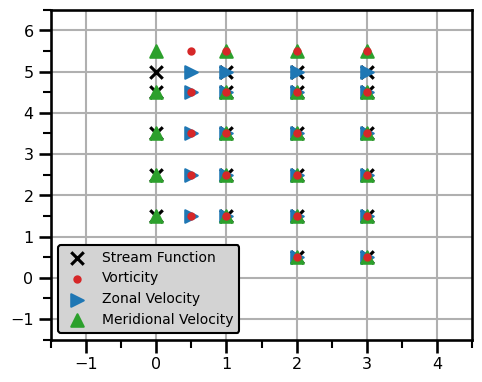

In [21]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(
    psi_x_on_v.values.ravel(),
    psi_y_on_v.values.ravel(),
    marker="x",
    color="black",
    zorder=2,
    label="Stream Function",
)
ax.scatter(
    q_x_on_v.values.ravel(),
    q_y_on_v.values.ravel(),
    marker=".",
    color="tab:red",
    zorder=3,
    label="Vorticity",
)
ax.scatter(
    u_x_on_v.values.ravel(),
    u_y_on_v.values.ravel(),
    marker=">",
    color="tab:blue",
    zorder=2,
    label="Zonal Velocity",
)
ax.scatter(
    v_x.values.ravel(),
    v_y.values.ravel(),
    marker="^",
    color="tab:green",
    zorder=2,
    label="Meridional Velocity",
)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.set(xlim=[-1.5, n_rows + 1.5], ylim=[-1.5, n_cols + 1.5])
ax.grid(
    which="major",
    zorder=1,
)
plt.legend(fontsize=10, edgecolor="black", framealpha=1.0, facecolor="lightgray")
plt.tight_layout()
plt.show()